# Tests using real data benchmarks

In this notebook, we run a series of experiments using well-known benchmark datasets.

In [1]:
## External modules.
from contextlib import ExitStack
from copy import deepcopy
from json import load as json_load
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.pyplot import savefig, show, subplots, tight_layout
from numpy import arange, nanargmin, array, expand_dims, linspace, loadtxt, median, vstack, zeros
from os import listdir, path

## Internal modules.
from mml.utils import makedir_safe
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend

In [2]:
## Specify the risk classes we want to consider.
riskclasses = ["erm", "rrisk", "trisk", "cvar", "entropic", "dro"]

risk_names = {"erm": "ERM",
              "rrisk": "M-risk",
              "trisk": "T-risk",
              "cvar": "CVaR risk",
              "entropic": "Entropic risk",
              "dro": r"$\chi^{2}$-DRO risk"}

In [3]:
## Choose the dataset we want to consider.
dataset = "iris"

In [4]:
## Choose a risk class, model, and learning algorithm combination.
loss_base = "logistic" # specify base loss name.
model = "linreg_multi" # specify model name
algo = "SGD_Ave" # specify algo name

In [5]:
## Directory setup.
makedir_safe(img_dir)
toread_dir = path.join(results_dir, dataset)

In [6]:
## Specify the evaluation metrics to look at.
ltype = "obj"
etypes = ["train", "val", "test"]

In [7]:
## Specify which epoch to use.
epoch_touse = -1

In [8]:
## Specify the statistic index to use.
stat_idx = 0 # mean is 0, median is 1, std is 2.

In [9]:
## Linestyles for discriminating train/val/test.
linestyles = {"train": "dotted",
              "val": "dashed",
              "test": "solid"}

In [10]:
## Extras naming etc.
extras_keys = {"erm": [],
               "rrisk": ["alpha"],
               "trisk": ["alpha"],
               "cvar": ["prob"],
               "entropic": ["gamma"],
               "dro": ["atilde"]}

extras_symbols = {"erm": [],
                  "rrisk": [r"$\alpha$"],
                  "trisk": [r"$\alpha$"],
                  "cvar": [r"$\beta$"],
                  "entropic": [r"$\gamma$"],
                  "dro": [r"$\widetilde{a}$"]}

def parse_extras(extras, risk_name):
    if risk_name == "erm":
        return None
    elif risk_name == "rrisk":
        return r"$\alpha=${}".format(extras["alpha"])
    elif risk_name == "trisk":
        return r"$\alpha=${}".format(extras["alpha"])
    elif risk_name == "cvar":
        return r"$\beta=${}".format(extras["prob"])
    elif risk_name == "entropic":
        return r"$\gamma=${}".format(extras["gamma"])
    elif risk_name == "dro":
        return r"$\widetilde a=${}".format(extras["atilde"])
    else:
        raise ValueError("Please pass a valid risk name.")

In [11]:
## Dictionary for storing the best/representative settings for each risk class.
best_settings = {riskclass: [] for riskclass in riskclasses}

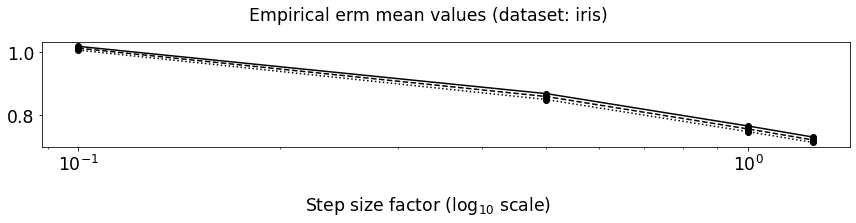

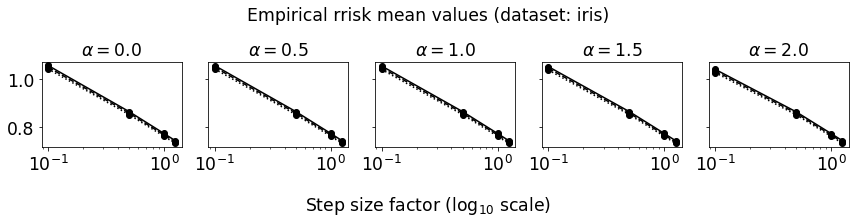

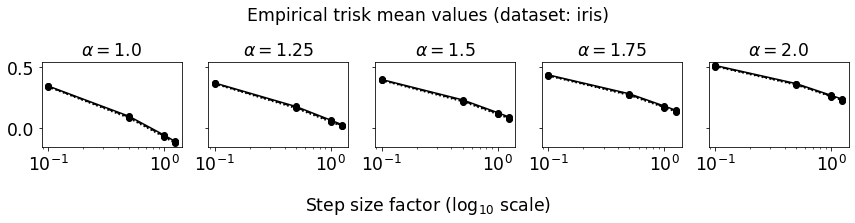

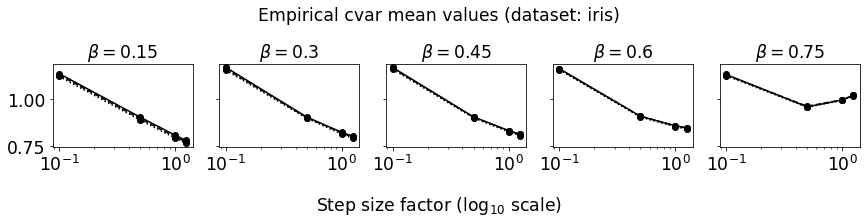

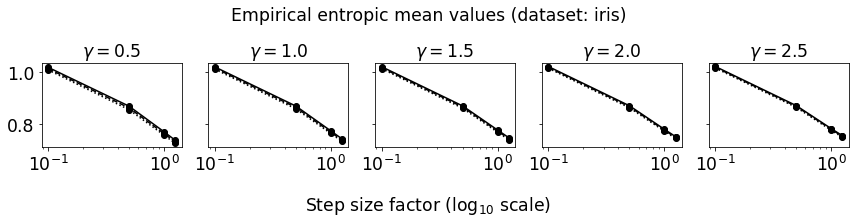

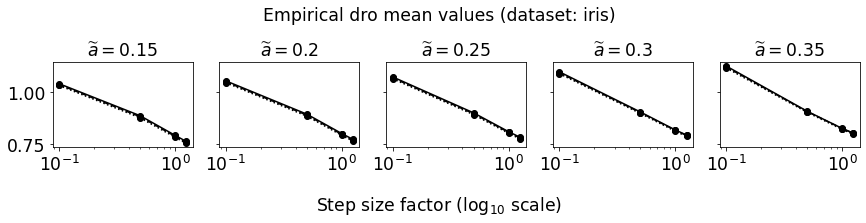

In [12]:
## Gathering, processing, and visualization all handled in one big loop.

for riskclass in riskclasses:
    
    ## Most of the filename is already specified.
    mth_base = riskclass+"_"+loss_base+"_"+model+"_"+algo
    
    ## Initialize a dict of results.
    results_dict = {}
    
    ## Gather the relevant hyperparameter indices to be parsed.
    all_files = listdir(toread_dir)
    r_values = []
    s_values = []
    for filename in all_files:
        _mth, extension = filename.split(".")
        if extension == "json":
            task, _mth_base = _mth.split("-")
            if mth_base == _mth_base:
                s_value, r_value = task.split("s")[1].split("r")
                if r_value not in r_values:
                    r_values += [r_value]
                if s_value not in s_values:
                    s_values += [s_value]
            else:
                continue
        else:
            continue
    num_r = len(r_values)
    num_s = len(s_values)
    if num_r > 0 and num_s > 0:
        ## Convert to integers, and sort.
        r_values = sorted([int(r) for r in r_values])
        s_values = sorted([int(s) for s in s_values])
    else:
        print("No results found for '{}' dataset.".format(dataset))
        continue
    
    ## Initial prep of the figure.
    fig, axes = subplots(1, num_r, figsize=(12,3), sharex=True, sharey=True)
    
    ## Now we can just loop over the relevant files.
    for i, r in enumerate(r_values):
        
        ## Relevant axis.
        ax = axes[i] if num_r > 1 else axes
        
        ## Storage for values to be plotted.
        x_values = []
        y_values_dict = {etype: [] for etype in etypes}
        
        for s in s_values:
            
            task = "s{}r{}".format(s, r)
            mth = "-".join([task, mth_base])
            
            ## Gather relevant information from the experiment JSON file.
            with open(path.join(toread_dir, ".".join([mth, "json"])), "r", encoding="utf-8") as f:
                json_dict = json_load(f)
                num_trials = json_dict["num_trials"]
                x_values += [json_dict["step_size"]]
                
                if s == 0:
                    ## Get risk function parameters at first inner step.
                    extras = {key: json_dict[key] for key in extras_keys[riskclass]}
                else:
                    ## After that, make sure they all match.
                    if not all([extras[key] == json_dict[key] for key in extras_keys[riskclass]]):
                        raise ValueError("Extras don't match.")
            
            ## Initialize a list for this specific risk setting.
            results = {etype: [] for etype in etypes}
            
            ## Gather the results of interest.
            for etype in results:
                for trial in range(num_trials):
                    ## Read in the results, add to a list that will be stacked soon.
                    fname = mth+"-"+str(trial)+"."+ltype+"_"+etype
                    with open(path.join(toread_dir, fname), "r", encoding="utf-8") as f:
                        values = loadtxt(fname=f, dtype=float, delimiter=",", ndmin=2)
                        ## Add results for the current trial.
                        results[etype] += [expand_dims(a=values, axis=0)]
                ## Having covered all trials, stack and process the arrays.
                y_values_dict[etype] += [ vstack(results[etype]).mean(axis=0)[epoch_touse,stat_idx] ]
                
            
        ## Plot these results.
        x_values = array(x_values)
        for etype in results:
            y_values = array(y_values_dict[etype])
            ax.semilogx(x_values, y_values, base=10, marker="o",
                        color="xkcd:black", ls=linestyles[etype])
        ax.tick_params(labelsize=my_fontsize)
        ax.set_title(parse_extras(extras=extras, risk_name=riskclass), size=my_fontsize)
        
        ## Store the best task.
        best_settings[riskclass] += ["s{}r{}".format(nanargmin(y_values_dict["train"]), r)]
    
        
    ## Title and horizontal axis label for the figure.
    fig.supxlabel(r"Step size factor ($\log_{10}$ scale)", size=my_fontsize)
    fig.suptitle("Empirical {} mean values (dataset: {})".format(riskclass, dataset), size=my_fontsize)
    
    ## Save and display the figure.
    #fname = path.join(img_dir, "traj_{}_reglines.{}".format(dataset, my_ext))
    tight_layout()
    #savefig(fname=fname)
    show()

Next, we visualize the trajectory (over time) of several key evaluation metrics of interest.

In [13]:
## Specify the risks for which we want to visualize trajectories.
riskclasses_tovis = ["erm", "trisk", "cvar", "entropic", "dro"]

In [14]:
## Specify the evaluation metrics to look at (from ["base", "obj", "zeroone", "l1", "l2"]).
ltypes = ["base", "zeroone"]
etype = "test" # either "train", "val", or "test"

In [15]:
## Prepare a dictionary for storing results.
results_allrisks = {}
json_dicts_allrisks = {}

In [16]:
## Gathering of results (for trajectories).

for riskclass in riskclasses_tovis:
    
    ## Initialize a list of results for each risk class.
    results_list = []
    json_dicts = []
    
    ## Grab the representative results.
    for task in best_settings[riskclass]:
        
        ## Identify the method for which we will gather results.
        mth = task+"-"+riskclass+"_"+loss_base+"_"+model+"_"+algo
        
        ## Gather relevant information from the experiment JSON file.
        with open(path.join(toread_dir, ".".join([mth, "json"])), "r", encoding="utf-8") as f:
            json_dict = json_load(f)
            num_trials = json_dict["num_trials"]
            
        ## Initialize a dictionary for this specific risk setting.
        results = {ltype: [] for ltype in ltypes}
        
        ## Gather the results of interest.
        for ltype in ltypes:
            for trial in range(num_trials):
                ## Read in the results, add to a list that will be stacked soon.
                fname = mth+"-"+str(trial)+"."+ltype+"_"+etype
                with open(path.join(toread_dir, fname), "r", encoding="utf-8") as f:
                    values = loadtxt(fname=f, dtype=float, delimiter=",", ndmin=2)
                    shape = values.shape
                ## Add results for the current trial.
                results[ltype] += [expand_dims(a=values, axis=0)]
            
            ## Having covered all trials, stack the arrays.
            results[ltype] = vstack(results[ltype])
        
        ## Store results for this risk setting.
        results_list += [deepcopy(results)]
        json_dicts += [deepcopy(json_dict)]
    
    ## Finally, store the results dictionary for the current risk class.
    results_allrisks[riskclass] = deepcopy(results_list)
    json_dicts_allrisks[riskclass] = deepcopy(json_dicts)

In [17]:
## Manual limits (top, bottom).
lims_base = {"adult": (None, None),
             "australian": (None, None),
             "cifar10": (2.5, None),
             "cod_rna": (None, None),
             "covtype": (None, None),
             "emnist_balanced": (None, None),
             "fashion_mnist": (1.0, None),
             "iris": (None, None),
             "mnist": (0.5, None),
             "protein": (0.1, None)}
lims_zeroone = {"adult": (0.25, None),
                "australian": (0.25, None),
                "cifar10": (0.75, None),
                "cod_rna": (0.2, None),
                "covtype": (0.4, None),
                "emnist_balanced": (0.75, None),
                "fashion_mnist": (0.3, None),
                "iris": (None, None),
                "mnist": (0.2, None),
                "protein": (0.1, None)}
lims = {"base": lims_base,
        "zeroone": lims_zeroone}

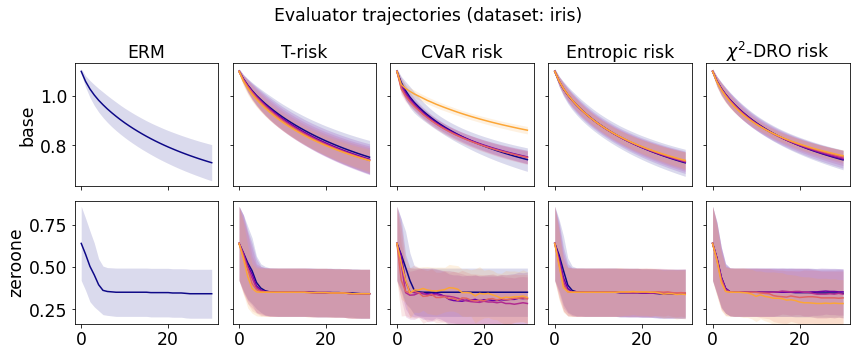

In [18]:
## Visualize the trajectories.

fig, axes = subplots(len(ltypes), len(riskclasses_tovis), figsize=(12,5), sharex=True, sharey="row")

## Loop over evaluation metrics.
for i, ltype in enumerate(ltypes):
    
    ## Row titles.
    axes[i,0].set_ylabel(ltype, size=my_fontsize)
    
    ## Loop over risk classes.
    for j, riskclass in enumerate(riskclasses_tovis):
        
        ## Result lists for this risk class.
        results_list = results_allrisks[riskclass]
        json_dicts = json_dicts_allrisks[riskclass]

        ## Relevant bits of information.
        num_risks = len(results_list)

        ## Color setup.
        cmap = cm.get_cmap("plasma")
        colours = [cmap(k/num_risks) for k in range(num_risks)]
        
        ## Loop over the individual risks.
        for k in range(num_risks):
            
            ## Actual results of interest for plotting.
            results = results_list[k]
            json_dict = json_dicts[k]
            
            ## More relevant bits of information.
            num_epochs = json_dict["num_epochs"]
            
            ## Values to be plotted.
            x_values = arange(num_epochs+1)
            y_values = results[ltype].mean(axis=0)[:,stat_idx]
            y_err = results[ltype].std(axis=0)[:,stat_idx]
        
            ## Plot results.
            axes[i,j].plot(x_values, y_values, color=colours[k])
            axes[i,j].fill_between(x=x_values, y1=y_values-y_err, y2=y_values+y_err,
                                   alpha=0.15, color=colours[k], lw=0)
            axes[i,j].set_ylim(top=lims[ltype][dataset][0], bottom=lims[ltype][dataset][1])
        
        ## Column titles.
        axes[i,j].tick_params(labelsize=my_fontsize)
        if i==0:
            axes[i,j].set_title(risk_names[riskclass], size=my_fontsize)

## Title for the figure.
fig.suptitle("Evaluator trajectories (dataset: {})".format(dataset), size=my_fontsize)

fname = path.join(img_dir, "real_traj_{}.{}".format(dataset, my_ext))
tight_layout()
savefig(fname=fname)
show()


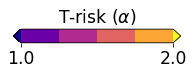

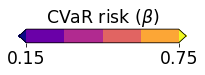

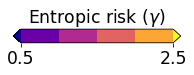

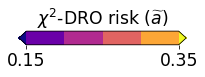

In [19]:
## If desired, we can prepare separate colorbars.
for j, riskclass in enumerate(riskclasses_tovis):
    results_list = results_allrisks[riskclass]
    num_risks = len(results_list)
    if num_risks > 1:
        fig, ax = subplots(figsize=(3, 0.5))
        fig.subplots_adjust(bottom=0.5)
        json_dicts = json_dicts_allrisks[riskclass]
        extras_name = extras_keys[riskclass][0]
        extras_symbol = extras_symbols[riskclass][0]
        bounds = array([ json_dicts[k][extras_name] for k in range(num_risks) ])
        cmap = cm.get_cmap("plasma")
        norm = BoundaryNorm(bounds, cmap.N, extend="both")
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                            cax=ax, orientation="horizontal")
        ax.tick_params(labelsize=my_fontsize)
        cbar.set_ticks([bounds.min(), bounds.max()])
        cbar.set_ticklabels([str(bounds.min()), str(bounds.max())])
        ax.set_title("{} ({})".format(risk_names[riskclass],extras_symbol),
                     size=my_fontsize)
        fname = path.join(img_dir, "real_colorbar_{}.{}".format(riskclass, my_ext))
        savefig(fname=fname, bbox_inches="tight") # use bbox_inches so text isn't cropped; uncomment to save.
        show()
    else:
        continue

In [20]:
## Specify the trial for which we want to check the distribution.
trial_touse = 0

In [21]:
## Prepare a dictionary for storing results.
results_allrisks = {}
json_dicts_allrisks = {}

In [22]:
## Gathering of results (for distributions).

for riskclass in riskclasses_tovis:
    
    ## Initialize a list of results for each risk class.
    results_list = []
    json_dicts = []
    
    ## Grab the representative results.
    for task in best_settings[riskclass]:
        
        ## Identify the method for which we will gather results.
        mth = task+"-"+riskclass+"_"+loss_base+"_"+model+"_"+algo
        
        ## Read in the relevant results and store.
        fname = mth+"-"+str(trial_touse)+"."+"dist"+"_"+"test"
        with open(path.join(toread_dir, fname), "r", encoding="utf-8") as f:
            ## Store results for this risk setting.
            results_list += [loadtxt(fname=f, dtype=float, delimiter=",")]
    
    ## Finally, store the results dictionary for the current risk class.
    results_allrisks[riskclass] = deepcopy(results_list)

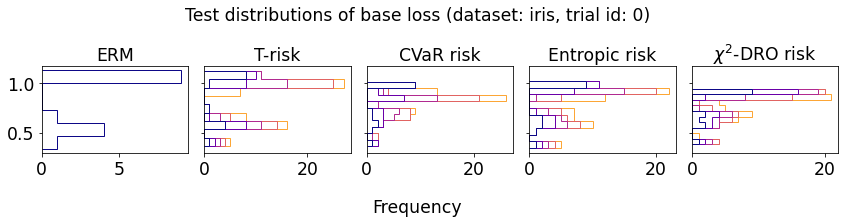

In [23]:
## Visualize the distributions.

fig, axes = subplots(1, len(riskclasses_tovis), figsize=(12,3), sharey=True)

for j, riskclass in enumerate(riskclasses_tovis):
    
    ## Get axis to plot with.
    ax = axes[j]
    
    ## Get result list.
    results_list = results_allrisks[riskclass]
    
    ## Relevant bits of information.
    num_risks = len(results_list)

    ## Color setup.
    cmap = cm.get_cmap("plasma")
    colours = [cmap(k/num_risks) for k in range(num_risks)]
    
    ## Plot all the results for the current risk class.
    ax.hist(results_list, bins="doane", color=colours,
            histtype="step", stacked=True, fill=False,
            hatch=None, orientation="horizontal", density=False)
    ax.tick_params(labelsize=my_fontsize)
    ax.set_title("{}".format(risk_names[riskclass]), size=my_fontsize)

## Title and horizontal label for the figure.
fig.suptitle("Test distributions of base loss (dataset: {}, trial id: {})".format(dataset, trial_touse),
             size=my_fontsize)
fig.supxlabel("Frequency", size=my_fontsize)

fname = path.join(img_dir, "real_hist_{}.{}".format(dataset, my_ext))
tight_layout()
savefig(fname=fname)
show()


___